In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy
import scipy.optimize
import scipy.stats as stats
import cvxpy
import warnings

from IPython.display import display
from PIL import Image

warnings.filterwarnings('ignore')

plt.style.use('../matplotlibrc')

In [17]:
def is_ext_pt(C, d, alpha, tol):
    # TODO: remove np.nonzero?
    T = C[np.nonzero(np.abs(C @ alpha + d) < tol)]
    
    if len(T) == 0:
        return False
    
    S = scipy.linalg.svd(T, compute_uv=False)
    singular = np.abs(S)
    
    if singular.sum() == 0.0:
        return False
    
    return np.sum((singular / singular.sum()) > tol) == C.shape[1]


def solve_lp(C, r, d):
    alpha = cvxpy.Variable(C.shape[1])
    
    objective = cvxpy.Minimize(r.T @ (C @ alpha + d))
    constraints = [C @ alpha + d >= 0]
    
    prob = cvxpy.Problem(objective, constraints)
    prob.solve()
    
    return prob.value, alpha.value


def camns_lp(Xn, N, tol_lp=1e-3, tol_extreme_points=1e-6):
    M = Xn.shape[0]
    L = Xn.shape[1]
    # TODO: maybe remove zeroed outputs

    # Affine set fitting
    d = Xn.mean(axis=0)
    U, S, V = scipy.linalg.svd((Xn - d).T, full_matrices=False)
    C = U[:, :N - 1]
    # it's quite big, so we should delete it to free up memory
    del V

    Q = np.zeros(L).reshape(-1, 1)
    hS = []

    while len(hS) < N:
        w = stats.norm().rvs(L)
        # do multiplication in this order, so we won't create a matrix of size (128 x 128)^2 = 256 Mb
        r = w - Q @ (Q.T @ w)

        p_star, alpha1 = solve_lp(C, r, d)
        q_star, alpha2 = solve_lp(C, -r, d)
        p_star = np.abs(p_star)
        q_star = np.abs(q_star)

        if alpha1 is None or alpha2 is None:
            raise RuntimeError('LP is unsolvable')

        if len(hS) == 0:
            if is_ext_pt(C, d, alpha1, tol_extreme_points):
                hS.append(C @ alpha1 + d)

            if is_ext_pt(C, d, alpha2, tol_extreme_points):
                hS.append(C @ alpha2 + d)
        else:
            if (p_star / np.linalg.norm(r) * np.linalg.norm(C @ alpha1 + d)) >= tol_lp:
                if is_ext_pt(C, d, alpha1, tol_extreme_points):
                    hS.append(C @ alpha1 + d)

            if (q_star / np.linalg.norm(r) * np.linalg.norm(C @ alpha2 + d)) >= tol_lp:
                if is_ext_pt(C, d, alpha2, tol_extreme_points):
                    hS.append(C @ alpha2 + d)

        if len(hS) > 0:
            Q, R = scipy.linalg.qr(np.array(hS).T, mode='economic')

    if len(hS) > N:
        hS = hS[:-1] if p_star > q_star else hS[:-2] + [hS[-1]]
    
    return hS

Noise matrix:
[[0.2 0.3 0.8 0.6]
 [0.  0.  0.2 0.4]
 [0.8 0.7 0.  0. ]]


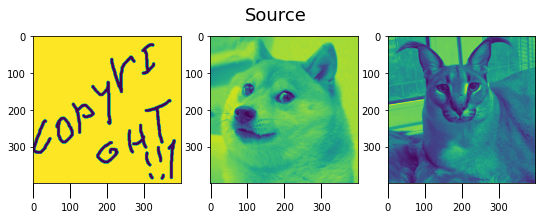

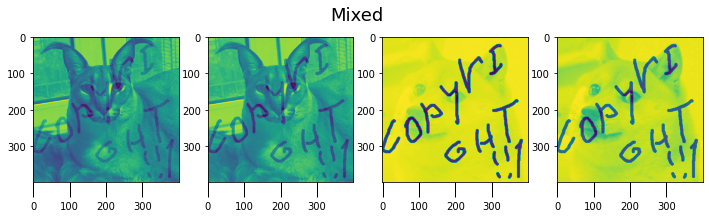

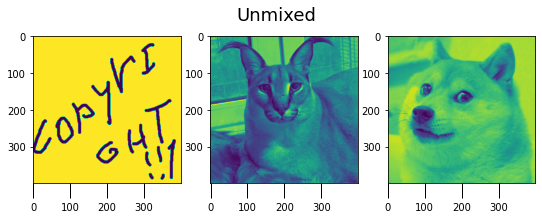

In [8]:
def image_to_vec(image):
    return (np.asarray(image) / 255).reshape(-1)


def vec_to_image(vec, width, height):
    return Image.fromarray((vec.reshape(height, width) * 255).clip(0, 255).astype(np.uint8))


def make_noise(source_count, mixed_count):
    noise = np.random.random((source_count, mixed_count))
    return noise / noise.sum(axis=0)


def show_images(images, title=''):
    count = len(images)
    fig, axes = plt.subplots(1, count, figsize=(count * 3, 3))

    for i, image in enumerate(images):
        axes[i].imshow(image)
        axes[i].imshow(image)
        axes[i].imshow(image)
    
    fig.suptitle(title, fontsize=18)

    plt.show()

    
def demo_method(images, noise_matrix):
    width, height = images[0].size
    assert all(image.size == (width, height) for image in images)

    source_count = len(images)

    sources = np.array(list(map(image_to_vec, images)))

    print('Noise matrix:')
    print(noise_matrix)

    mixed = noise_matrix.T @ sources
    mixed_images = [vec_to_image(data, width, height) for data in mixed]

    show_images(images, 'Source')
    show_images(mixed_images, 'Mixed')

    out = camns_lp(mixed, source_count)
    unmixed_images = [vec_to_image(data, width, height) for data in out]
    show_images(unmixed_images, 'Unmixed')


image_1 = Image.open('./dumb_watermark.png').convert('L')
image_2 = Image.open('./cat_sock.png').convert('L')
image_3 = Image.open('./big_floppa.png').convert('L')
image_4 = Image.open('./watermark.png').convert('L')
image_5 = Image.open('./funny_yellow_dog.png').convert('L')

normalized_noise = np.array([
    [0.2, 0.3, 0.8, 0.6],
    [0.0, 0.0, 0.2, 0.4],
    [0.8, 0.7, 0.0, 0.0]
])
demo_method([image_1, image_5, image_3], normalized_noise)

Noise matrix:
[[0.2 0.3 0.8 0.6]
 [0.  0.  0.2 0.4]
 [0.8 0.7 0.  0. ]]


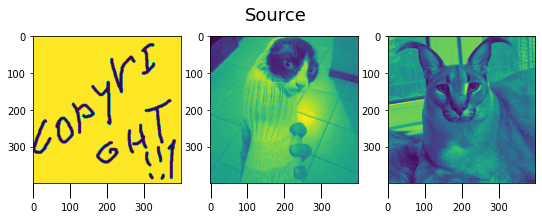

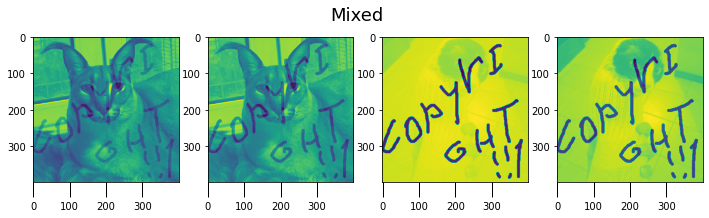

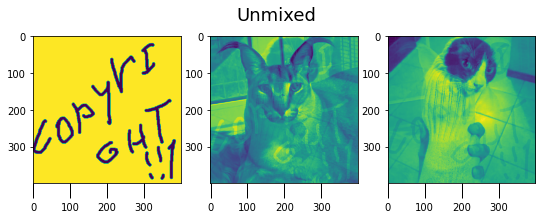

In [19]:
demo_method([image_1, image_2, image_3], normalized_noise)

Noise matrix:
[[0.65146001 0.35298684 0.76144256]
 [0.05060385 0.22046629 0.00099154]
 [0.29793614 0.42654688 0.2375659 ]]


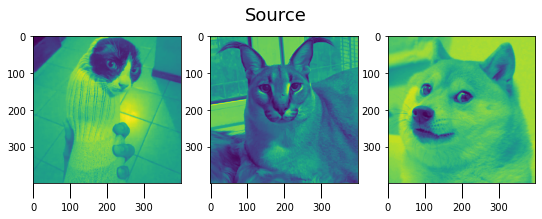

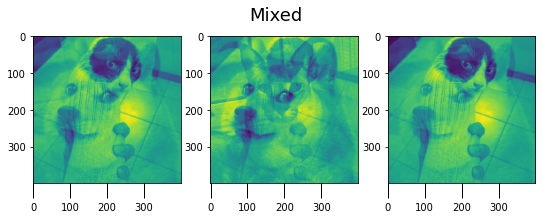

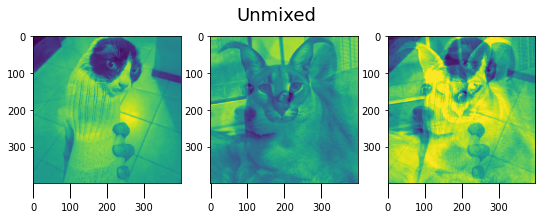

In [6]:
demo_method([image_2, image_3, image_5], make_noise(3, 3))

Noise matrix:
[[0.18926781 0.06608228 0.22425865]
 [0.26647718 0.32902969 0.36243143]
 [0.54425501 0.60488803 0.41330993]]


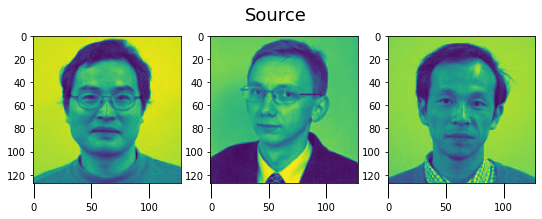

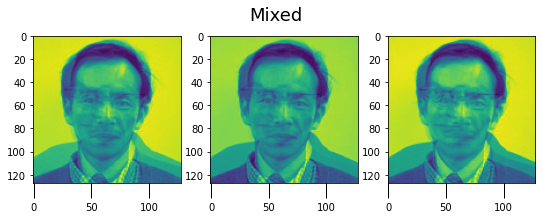

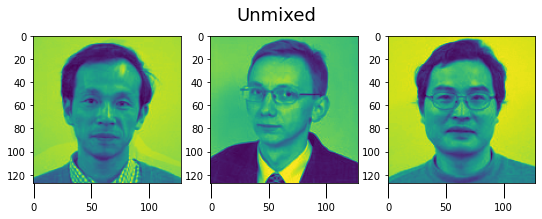

In [7]:
image_1 = Image.open('./cao1.jpg').convert('L')
image_2 = Image.open('./ksiwek1.jpg').convert('L')
image_3 = Image.open('./zhang1.jpg').convert('L')
demo_method([image_1, image_2, image_3], make_noise(3, 3))

**Вывод:** 

## Предположения

![Предположения](./assumptions_slide.png)

1 для картинок выполнено всегда, гарантировать 3 и 4 легко - просто генерим правильную матрицу шума. А вот 2 
предположение в точности не выполняется, только с какой-то точностью (т.к. нулевые пиксели не всегда есть).

В связи с этим метод работает не всегда - иногда ломается вообще, иногда плохо разделяет. 

Но когда работает - то результат неплохой, это даже можно использовать чтобы какие-нибудь вотермарки стирать.

## Алгоритм

![Алгоритм](./algorithm_slide.png)

Сам метод работает так:

Зашумленные картинки преобразуем в вектора, из них строим выпулкую оболочку. Дальше ищем ее вершины - они и
дадут ответ. Вершины ищем так - генерируем случайный вектор и минимизируем и максимизируем скалярное произведение
искомой точки с ним, причем точки берем удовлетворяющие уравнению выпуклой оболчки - получаем 2 задачи линейгого 
программирования, решаем их. В результате получаем 2 точки и дальше берем одну или 2 в зависимости от некоторого
условия. Дальше строим новый случайный вектор по определенному правилу и решаем такую же задачу, пока не получим
достаточно точек. В итоге мы можем получить одну лишнюю точку - ее отбрасываем.